# Diabetic Retinopathy Detection in CFPs using CNNs

**IMPORTANT DETAILS ABOUT THE WRITEUP:**

**Due to difficulties associated with Google Colab environment (specifically with loading images in MD cells), the writeup for this project is contained in the PDF document titled "ml_final_ssong21" (approved by Professor Spector).**

# Setting up libraries and mounting drive to access CFP image dataset

In [ ]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from keras import backend as K
from google.colab import drive
from keras.callbacks import EarlyStopping, ModelCheckpoint
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


Importing CFP images used for training the DCNN model

In [ ]:
import pathlib
!unzip -q "/content/drive/My Drive/final_photos_all.zip"
data_dir_train = pathlib.Path('/content/final_photos_all/train')
data_dir_test = pathlib.Path('/content/final_photos_all/test')  

replace final_photos_all/test/Stage 0/16021_leftP.jpeg? [y]es, [n]o, [A]ll, [N]one, [r]ename: A


In [ ]:
image_count = len(list(data_dir_train.glob('Stage 0/*.jpeg')))
print('Stage 0: ', image_count)
image_count = len(list(data_dir_train.glob('Stage 1+/*.jpeg')))
print('Stage 1+: ', image_count)
print('Total # training images: ', len(list(data_dir_train.glob('*/*.jpeg'))))

Stage 0:  473
Stage 1+:  473
Total # training images:  946


# Making training, validation, and testing datasets from the CFP images

Setting up input image size and batch size

In [ ]:
batch_size = 32
img_height = 180
img_width = 180

Making training dataset (using 80% of images in training folder)

In [ ]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="training",
  label_mode='binary',
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)
class_names = train_ds.class_names
print(class_names)

Found 946 files belonging to 2 classes.
Using 757 files for training.
['Stage 0', 'Stage 1+']


Making validation dataset (using 20% of images in training folder)

In [ ]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="validation",
  label_mode='binary',
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 946 files belonging to 2 classes.
Using 189 files for validation.


Making testing dataset (using all images in testing folder)

In [ ]:
testing_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_test,
  seed=123,
  label_mode='binary',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 80 files belonging to 2 classes.


A sample of 10 images from the training dataset

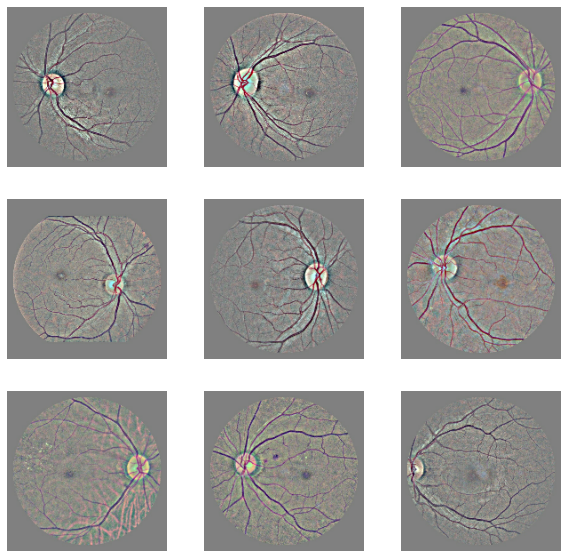

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.axis("off")

# Creating a CNN with a simple Sequential model

Implementing data augmentation, which artificially expands the size of the training dataset by creating modified versions of images in the dataset, reducing overfitting. Employs the following preprocessing layers:


*   RandomFlip, which randomly flips images horizontally
*   RandomRotation, which randomly rotates images
*   RandomZoom, which randomly zooms images 



In [ ]:
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)), # randomly flips images horizontally 
    layers.experimental.preprocessing.RandomRotation(0.13), # randomly rotates images with factor 0.13
    layers.experimental.preprocessing.RandomZoom(0.13), # randomly zooms images with factor 0.13
  ]
)

A Sequential Model that contains the following layers in order:



*   Data Augmentation layer
*   Rescaling Layer that standardizes RGB channel values from [0,255] to [0,1]
*   32-filter Conv2D Layer with kernel size of 3x3 and ReLU activation
*   MaxPooling2D layer with default arguments
*   64-filter Conv2D Layer with kernel size of 3x3 and ReLU activation
*   MaxPooling2D layer with default arguments
*   Dropout Layer with ratio of 0.3
*   128-filter Conv2D Layer with kernel size of 3x3, ReLU activation, and L2 regularization
*   MaxPooling2D layer with default arguments
*   Dropout Layer with ratio of 0.3
*   Flatten Layer
*   128-unit dense layer with ReLU activation and L2 regularization
*   Dropout Layer with ratio of 0.4
*   1-unit dense layer with sigmoid activation for binary classification





In [ ]:
model = Sequential([
  data_augmentation, # Data augmentation in order to artificially expand the size of training dataset by creating modified versions of images in the dataset, reducing overfitting
  layers.experimental.preprocessing.Rescaling(1./255), # Standardizing the RGB channel values from [0, 255] to [0,1] via a Rescaling layer to improve training performance
  layers.Conv2D(32, 3, activation='relu'), #32 filters, kernel size of 3x3, ReLU activation
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, activation='relu'), #64 filters, kernel size of 3x3, ReLU activation
  layers.MaxPooling2D(),
  layers.Dropout(0.3),
  layers.Conv2D(128, 3, activation='relu', kernel_regularizer='l2'), #128 filters, kernel size of 3x3, ReLU activation, L2 regularization
  layers.MaxPooling2D(),
  layers.Dropout(0.3), # Dropout regularization in order to reduce overfitting
  layers.Flatten(),
  layers.Dense(128, activation='relu', kernel_regularizer='l2'), #128 units, dense layer with ReLU activation, L2 regularization
  layers.Dropout(0.4), # Dropout regularization in order to reduce overfitting
  layers.Dense(1, activation ='sigmoid') #1 unit dense layer, sigmoid activation for binary classification
])

Compiling the Sequential model using accuracy, sensitivity, and specificity as performance metrics.


*   Optimizer = RMSprop (initial LR = 0.00001)
*   Loss Function = Binary Cross Entropy
*   See writeup for more details





In [ ]:
def sensitivity(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())

def specificity(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1-y_true) * (1-y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1-y_true, 0, 1)))
    return true_negatives / (possible_negatives + K.epsilon())

model.compile(optimizer=keras.optimizers.RMSprop(learning_rate=0.00001),
              loss='binary_crossentropy',
              metrics=['accuracy', sensitivity, specificity])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 180, 180, 3)       0         
_________________________________________________________________
rescaling (Rescaling)        (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 178, 178, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 89, 89, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 87, 87, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 43, 43, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 43, 43, 64)       

Printing out a graphic of the model architecture

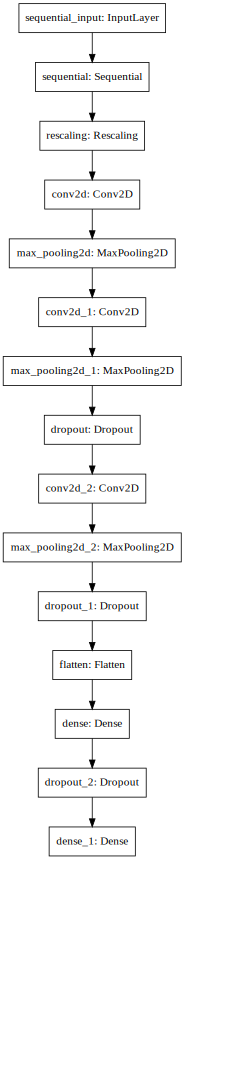

In [ ]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
SVG(model_to_dot(model, dpi=58).create(prog='dot', format='svg'))

# Training the CNN

In [ ]:
epochs = 600
history = model.fit(train_ds, validation_data = val_ds, epochs = epochs)

Epoch 1/600
24/24 [==============================] - 3s 143ms/step - loss: 4.0256 - accuracy: 0.4980 - sensitivity: 0.4769 - specificity: 0.5175 - val_loss: 3.9749 - val_accuracy: 0.4550 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00
Epoch 2/600
24/24 [==============================] - 3s 129ms/step - loss: 3.9218 - accuracy: 0.4822 - sensitivity: 0.5877 - specificity: 0.3770 - val_loss: 3.8704 - val_accuracy: 0.4550 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00
Epoch 3/600
24/24 [==============================] - 3s 129ms/step - loss: 3.8218 - accuracy: 0.5033 - sensitivity: 0.6788 - specificity: 0.3485 - val_loss: 3.7690 - val_accuracy: 0.4550 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00
Epoch 4/600
24/24 [==============================] - 3s 128ms/step - loss: 3.7218 - accuracy: 0.4954 - sensitivity: 0.4906 - specificity: 0.4976 - val_loss: 3.6754 - val_accuracy: 0.4550 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00
Epoch 5/600
24/24 [=========

# Visualizing the Training Results

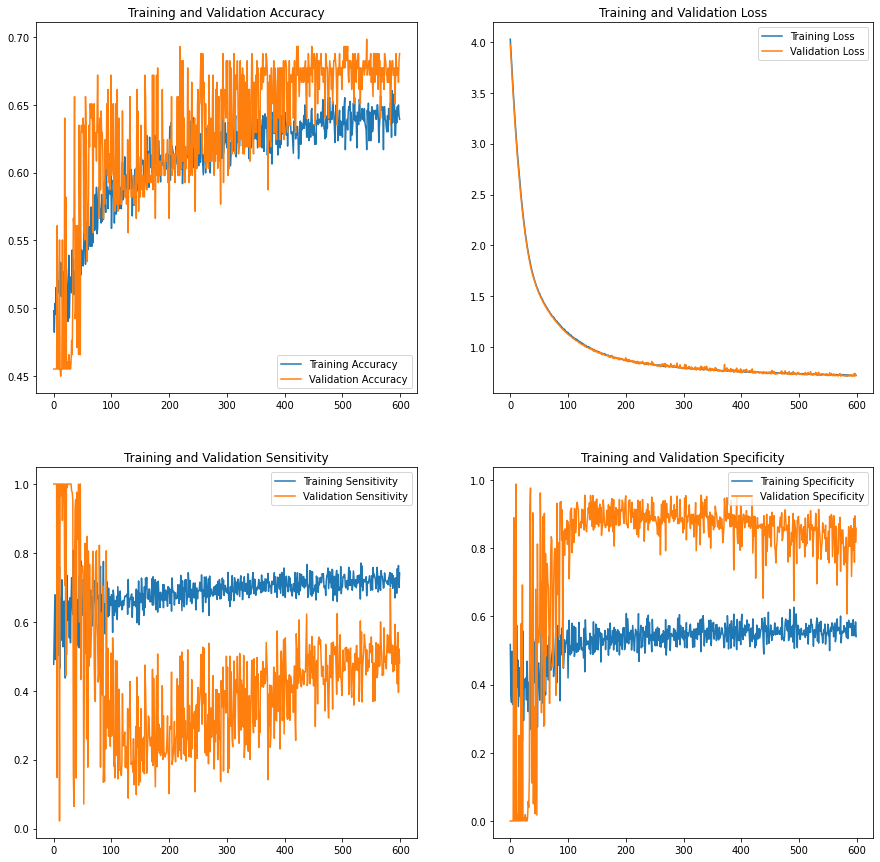

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

sen = history.history['sensitivity']
val_sen = history.history['val_sensitivity']

spe = history.history['specificity']
val_spe = history.history['val_specificity']

epochs_range = range(len(history.history['accuracy']))

plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.subplot(2, 2, 3)
plt.plot(epochs_range, sen, label='Training Sensitivity')
plt.plot(epochs_range, val_sen, label='Validation Sensitivity')
plt.legend(loc='upper right')
plt.title('Training and Validation Sensitivity')

plt.subplot(2, 2, 4)
plt.plot(epochs_range, spe, label='Training Specificity')
plt.plot(epochs_range, val_spe, label='Validation Specificity')
plt.legend(loc='upper right')
plt.title('Training and Validation Specificity')

plt.show()


# Evaluating the trained model on the test dataset based on accuracy, sensitivity, and specficity



In [ ]:
model.evaluate(testing_ds)

3/3 [==============================] - 0s 10ms/step - loss: 0.8666 - accuracy: 0.5250 - sensitivity: 0.3444 - specificity: 0.7484


[0.8666248321533203,
 0.5249999761581421,
 0.3444444239139557,
 0.7483660578727722]

# Saving and Loading Models (NOT TO BE RUN DURING EVALUATIONS, FOR DEBUGGING PURPOSES)


*   **Make sure these cells are commented out when running the notebook to avoid potential errors!**



Saving the model (not to be run during evaluation, for debugging purposes)

In [ ]:
##model = keras.models.load_model('/content/drive/My Drive/models_test/basic_250/', custom_objects={'specificity':specificity, 'sensitivity':sensitivity})

Loading a saved model (not to be run during evaluation, for debugging purposes)

In [ ]:
##model.save('/content/drive/My Drive/models_test/good_250_lowLR/')